# Pneumonia Final Project

# Setup & Utils

### Imports

In [ ]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import shutil
import tensorflow as tf
import keras
from keras import optimizers
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, UpSampling2D, Cropping2D
from keras.saving import save_model, load_model
from keras.optimizers import Adam
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
    classification_report,
    balanced_accuracy_score,
)
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from pathlib import Path
from tqdm import tqdm
from google.colab import files

### Constants

In [ ]:
# File hierarchy constants
BASE_DIR = r'/content'
DATA_DIR = Path(BASE_DIR, 'chest_xray')
MODELS_DIR = Path(BASE_DIR, 'models')

TRAIN_DIR = Path(DATA_DIR, 'train')
VAL_DIR = Path(DATA_DIR, 'val')
TEST_DIR = Path(DATA_DIR, 'test')

NORMAL_LABEL = 'NORMAL'
PNEUMONIA_LABEL = 'PNEUMONIA'

# Data constants
SIZE = 150
RESCALE =  1./255

### File Utils

In [ ]:
def copy_files(src_dir, dst_dir):
    if not os.path.exists(src_dir):
      raise ValueError(f"Source directory '{src_dir}' does not exist")

    if not os.path.exists(dst_dir):
      raise ValueError(f"Destination directory '{dst_dir}' does not exist")

    for file in os.listdir(src_dir):
        source_file_path = os.path.join(src_dir, file)
        destination_file_path = os.path.join(dst_dir, file)
        shutil.copy(source_file_path, destination_file_path)


def copy_dir(src_dir, dst_dir, replace_dir=True):
    if not os.path.exists(src_dir):
        raise ValueError(f"Source directory '{src_dir}' does not exist")

    if replace_dir:
        delete_dir(dst_dir)

    shutil.copytree(src_dir, dst_dir)


def delete_dir(dir):
  if os.path.exists(dir):
    shutil.rmtree(dir)
    print(f"Deleted existing destination directory: {dir}")


def create_dir(dir):
  if not os.path.exists(dir):
    os.makedirs(dir)


def move_random_files(src_dir, dst_dir, count):
    if not os.path.exists(src_dir):
      raise ValueError(f"Source directory '{src_dir}' does not exist")

    if not os.path.exists(dst_dir):
      create_dir(dst_dir)

    files = os.listdir(src_dir)

    if count > len(files):
      raise ValueError(f'Were asked to copy {count} files while there were only {len(files)} at {src_dir}')

    files_to_move = random.sample(files, count)

    for file_name in files_to_move:
        src = os.path.join(src_dir, file_name)
        dst = os.path.join(dst_dir, file_name)
        shutil.move(src, dst)

### Visualizations

In [ ]:
def plot_loss_and_accuracy(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()


def display_model_performance_evaluation(y_test, y_pred, classes):
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix:\n{cm}')
    cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
    cmd.plot()
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {round(accuracy * 100)}%')
    print()

    TP = cm.diagonal()
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (TP + FP + FN)

    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = FP / (FP + TN)
    FNR = FN / (FN + TP)

    print("Class-wise metrics:")
    for i, class_name in enumerate(classes):
        print(f'Class: {class_name}')
        print(f'TPR: {round(TPR[i] * 100)}%')
        print(f'TNR: {round(TNR[i] * 100)}%')
        print(f'FPR: {round(FPR[i] * 100)}%')
        print(f'FNR: {round(FNR[i] * 100)}%')
        print()

    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print(f'Balanced Accuracy: {round(bal_acc * 100)}%')
    print()


def display_knn_matrix(embeddings_train, labels):
  tsne = TSNE(n_components=2, random_state=42)
  embeddings_2d = tsne.fit_transform(embeddings_train)

  plt.figure(figsize=(10, 8))
  colors = ['r', 'g', 'b', 'y']
  for i in range(len(embeddings_2d)):
      plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], c=colors[labels[i]], marker='.')

  plt.title('KNN Distribution')
  plt.xlabel('t-SNE Dimension 1')
  plt.ylabel('t-SNE Dimension 2')
  plt.show()


def display_generator_sample(data_generator):
  print(f"Number of classes: {len(data_generator[0])}")
  print(f"Batch size: {len(data_generator[0][0])}")
  print(f"Number of batches in train set: {len(data_generator)}")
  print(f"Classes: {data_generator.class_indices}")
  img = random.choice(data_generator[0][0])
  plt.imshow(img, cmap='gray')
  print(f"Image shape: {img.shape}")

### Uploading Utils

In [ ]:
from google.colab import files as colabfiles

def upload_image():
  uploaded = colabfiles.upload()
  for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

  return uploaded


def process_image_for_prediction(size = SIZE):
  image_string = list(upload_image().values())[0]
  image = tf.io.decode_image(image_string, channels=1)
  image = tf.image.resize(image, (size, size))
  image_tensor = tf.expand_dims(image, axis=0)
  binary_array = np.asarray(image_tensor)
  binary_array.reshape(1,-1)
  binary_array = binary_array / 255

  return binary_array

# Task 1 - Detecting Pneumonia
------
In this assignment, we were tasked with constructing a neural network designed to differentiate between images depicting lungs afflicted with pneumonia and those that are not.

### Preparing the data set
In this section we copy all the training data into `train` directory, and `VAL_DATA_PERCENT_OF_TRAIN` percent of them into `val` directory

In [ ]:
TASK_1_DIR = Path(BASE_DIR, 'task1')
TRAIN_1_DIR = Path(TASK_1_DIR, 'train')
VAL_1_DIR = Path(TASK_1_DIR, 'val')

delete_dir(TASK_1_DIR)

# Preparing train folder
copy_dir(TRAIN_DIR, TRAIN_1_DIR)
copy_files(Path(VAL_DIR, NORMAL_LABEL), Path(TRAIN_1_DIR, NORMAL_LABEL))
copy_files(Path(VAL_DIR, PNEUMONIA_LABEL), Path(TRAIN_1_DIR, PNEUMONIA_LABEL))

# Preparing val folder
VAL_DATA_PERCENT_OF_TRAIN = 12
VAL_FILE_COUNT = int(len(os.listdir(Path(TRAIN_1_DIR, PNEUMONIA_LABEL))) / VAL_DATA_PERCENT_OF_TRAIN)
VAL_fFILE_COUNT = int(len(os.listdir(Path(TRAIN_1_DIR, NORMAL_LABEL))) / VAL_DATA_PERCENT_OF_TRAIN)

move_random_files(Path(TRAIN_1_DIR, NORMAL_LABEL), Path(VAL_1_DIR, NORMAL_LABEL), VAL_fFILE_COUNT)
move_random_files(Path(TRAIN_1_DIR, PNEUMONIA_LABEL), Path(VAL_1_DIR, PNEUMONIA_LABEL), VAL_FILE_COUNT)

### Loading the data set

In [ ]:
data_gen = ImageDataGenerator(rescale=RESCALE)

train_generator = data_gen.flow_from_directory(
    TRAIN_1_DIR,
    target_size=(SIZE, SIZE),
    class_mode="binary",
    shuffle=False,
    batch_size=64,
    color_mode="grayscale",
)

val_generator = data_gen.flow_from_directory(
    VAL_1_DIR,
    target_size=(SIZE, SIZE),
    class_mode="binary",
    shuffle=False,
    batch_size=64,
    color_mode="grayscale",
)

test_generator = data_gen.flow_from_directory(
    TEST_DIR,
    target_size=(SIZE, SIZE),
    class_mode="binary",
    shuffle=False,
    batch_size=64,
    color_mode="grayscale",
)


Found 4797 images belonging to 2 classes.
Found 435 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Number of classes: 2
Batch size: 64
Number of batches in train set: 75
Classes: {'NORMAL': 0, 'PNEUMONIA': 1}
Image shape: (150, 150, 1)


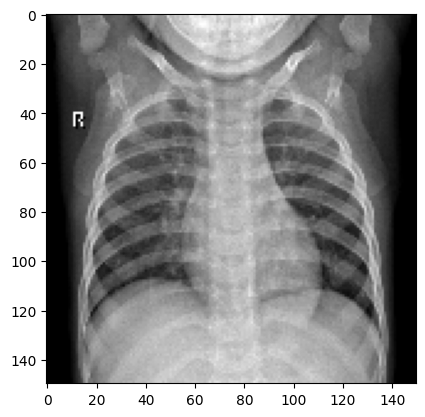

In [ ]:
display_generator_sample(train_generator)

### Building and Training the model

#### The model's architecture
The architecture of this model, comprising convolutional layers followed by max pooling layers, is well-suited for image classification tasks.

We have incorporated a dropout layer with a rate of 0.4. Dropout layers mitigate overfitting by randomly omitting a fraction of neurons during training.

The output layer utilizes a sigmoid activation because the model is designed for binary classification.

We've experimented with more complex techniques, and here's what we've observed:

- **Adding Image Augmentations**: In theory, this should introduce more training diversity, reducing overfitting and creating a more generalized model. When attempting this in practice (adjusting image zoom, rotation, etc.), we did observe some improvement in the model to a certain degree. However, we ultimately decided to stick to the basics.

- **Adding a Cropping Layer**: Introducing a cropping layer to remove irrelevant parts of the image is intended to guide the model toward focusing on important areas. While we did achieve some success with this approach, we ultimately chose to retain the original data. We cannot assume uniformity across all images, and determining which parts are more relevant proved challenging, as none of us are experts in this domain.

#### Adam optimaizer
We use the Adam optimizer to dynamically adjust the model's parameters throughout the training process. This dynamic adaptation enables individual learning rates to evolve as necessary, ensuring optimal adjustments. The automated optimization process eliminates the need for manual fine-tuning, resulting in a time-efficient and streamlined model development.

In [ ]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(SIZE, SIZE, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, (3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(96, (3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1 , activation='sigmoid')
])

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

print(f'Model summary:\n{model.summary()}')
print('Model Architecture:')
plot_model(model, show_shapes=True)

#### Early stopping
We employ early stopping to oversee the model's training session. Deep learning models often show improvement up to a certain point, after which they may decline when becoming overly tailored to the training data, leading to overfitting.

We specifically monitor validation loss because the model should not be trained on the validation data. Early stopping intervenes to restore the best weights in the event that the model indeed begins to overfit, ensuring optimal generalization to unseen data.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=10,
    callbacks=[early_stopping],
    validation_data=val_generator)

### Evaluating model

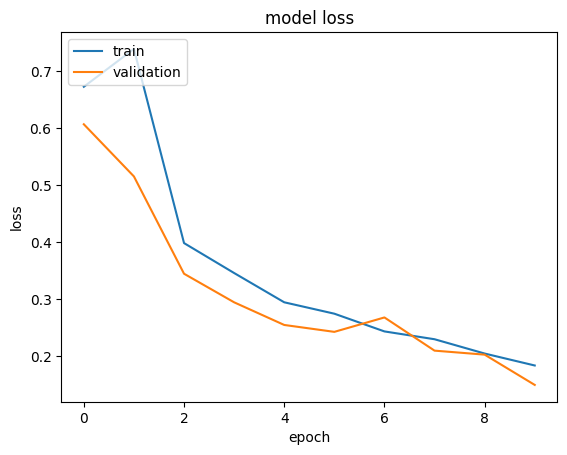

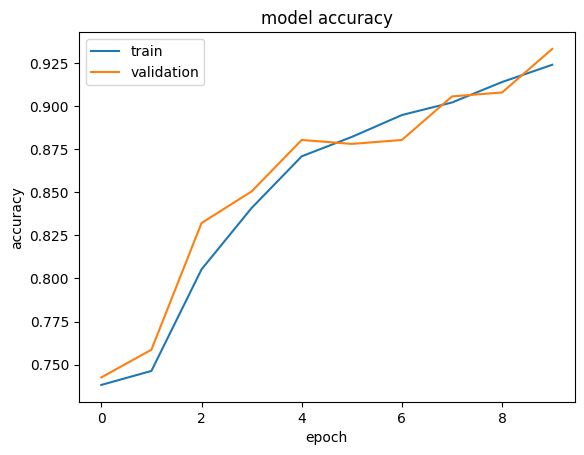

In [ ]:
plot_loss_and_accuracy(history)

10/10 [==============================] - 3s 246ms/step
Confusion Matrix:
[[143  91]
 [ 14 376]]
Accuracy: 83%

Class-wise metrics:
Class: NORMAL
TPR: 61%
TNR: 96%
FPR: 4%
FNR: 39%

Class: PNEUMONIA
TPR: 96%
TNR: 61%
FPR: 39%
FNR: 4%

Balanced Accuracy: 79%



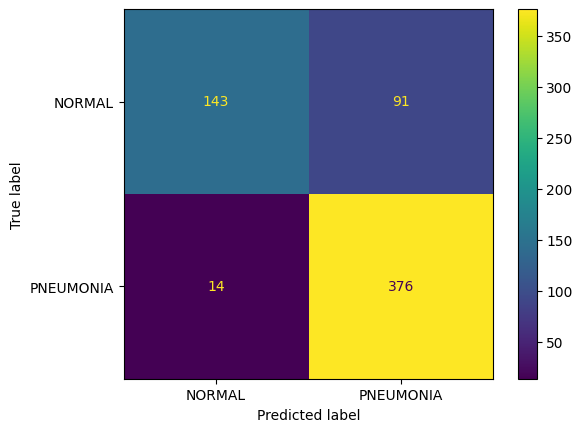

In [ ]:
y_pred = model.predict(test_generator)

y_pred = (np.round(y_pred)).flatten()
y_test = test_generator.classes
y_test_names = test_generator.class_indices.keys()
display_model_performance_evaluation(y_test, y_pred, y_test_names)

### Saving the model

In [ ]:
model.save(Path(MODELS_DIR, 'task1'))

# Task 2 - Detection Bacterial and Viral Pneumonia
-----
This task resembles the previous one, but it requires distinguishing between two types of pneumonia: viral and bacterial.

### Preparing the data set

In [ ]:
def split_dir_by_label(src_dir, string_to_match, label_1, label_2):
    parent_dir = os.path.dirname(src_dir)

    label_1_path = Path(parent_dir, label_1)
    label_2_path = Path(parent_dir, label_2)
    create_dir(label_1_path)
    create_dir(label_2_path)

    for filename in os.listdir(src_dir):
        if os.path.isfile(os.path.join(src_dir, filename)):
            if string_to_match in filename:
                shutil.copy(os.path.join(src_dir, filename), os.path.join(label_1_path, filename))
            else:
                shutil.copy(os.path.join(src_dir, filename), os.path.join(label_2_path, filename))
    delete_dir(src_dir)

In [ ]:
VIRUS_LABEL = 'VIRUS'
BACTERIA_LABEL = 'BACTERIA'

TASK_2_DIR = Path(BASE_DIR, 'task2')

TRAIN_2_DIR = Path(TASK_2_DIR, 'train')
VAL_2_DIR = Path(TASK_2_DIR, 'val')
TEST_2_DIR = Path(TASK_2_DIR, 'test')

delete_dir(TASK_2_DIR)

# Preparing train folder
copy_dir(Path(TRAIN_DIR, NORMAL_LABEL), Path(TRAIN_2_DIR, NORMAL_LABEL))
copy_files(Path(VAL_DIR, NORMAL_LABEL), Path(TRAIN_2_DIR, NORMAL_LABEL))
copy_dir(Path(TRAIN_DIR, PNEUMONIA_LABEL), Path(TRAIN_2_DIR, PNEUMONIA_LABEL))
copy_files(Path(VAL_DIR, PNEUMONIA_LABEL), Path(TRAIN_2_DIR, PNEUMONIA_LABEL))
split_dir_by_label(Path(TRAIN_2_DIR, PNEUMONIA_LABEL), 'bacteria', BACTERIA_LABEL, VIRUS_LABEL)

# Preparing val folder
VAL_DATA_PERCENT_OF_TRAIN = 5
A = int(len(os.listdir(Path(TRAIN_2_DIR, VIRUS_LABEL))) * (VAL_DATA_PERCENT_OF_TRAIN / 100) )
B = int(len(os.listdir(Path(TRAIN_2_DIR, BACTERIA_LABEL))) * (VAL_DATA_PERCENT_OF_TRAIN / 100) )
C = int(len(os.listdir(Path(TRAIN_2_DIR, NORMAL_LABEL))) * (VAL_DATA_PERCENT_OF_TRAIN / 100) )

move_random_files(Path(TRAIN_2_DIR, NORMAL_LABEL), Path(VAL_2_DIR, NORMAL_LABEL), C)
move_random_files(Path(TRAIN_2_DIR, BACTERIA_LABEL), Path(VAL_2_DIR, BACTERIA_LABEL), B)
move_random_files(Path(TRAIN_2_DIR, VIRUS_LABEL), Path(VAL_2_DIR, VIRUS_LABEL), A)

# Preparing test folder
copy_dir(TEST_DIR, TEST_2_DIR)
split_dir_by_label(Path(TEST_2_DIR, PNEUMONIA_LABEL), 'bacteria', BACTERIA_LABEL, VIRUS_LABEL)

Deleted existing destination directory: /content/task2
Deleted existing destination directory: /content/task2/train/PNEUMONIA
Deleted existing destination directory: /content/task2/test/PNEUMONIA


### Loading the data set

In [ ]:
data_gen = ImageDataGenerator(rescale=RESCALE)

train_generator = data_gen.flow_from_directory(
    TRAIN_2_DIR,
    target_size=(SIZE, SIZE),
    class_mode="categorical",
    shuffle=False,
    batch_size=64,
    color_mode="grayscale",
)

val_generator = data_gen.flow_from_directory(
    VAL_2_DIR,
    target_size=(SIZE, SIZE),
    class_mode="categorical",
    shuffle=False,
    batch_size=64,
    color_mode="grayscale",
)

test_generator = data_gen.flow_from_directory(
    TEST_2_DIR,
    target_size=(SIZE, SIZE),
    class_mode="categorical",
    shuffle=False,
    batch_size=64,
    color_mode="grayscale",
)


Found 4186 images belonging to 3 classes.
Found 1046 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


Number of classes: 2
Batch size: 64
Number of batches in train set: 66
Classes: {'BACTERIA': 0, 'NORMAL': 1, 'VIRUS': 2}
Image shape: (150, 150, 1)


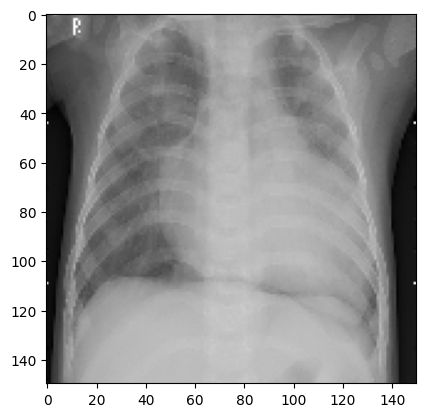

In [ ]:
display_generator_sample(train_generator)

### Building and Training the model

In [ ]:
model = Sequential([
      Conv2D(32, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 1)),
      MaxPooling2D((2, 2)),
      Conv2D(64, (3, 3), activation="relu"),
      MaxPooling2D((2, 2)),
      Conv2D(128, (3, 3), activation="relu"),
      MaxPooling2D((2, 2)),
      Flatten(),
      Dense(128, activation="relu"),
      Dense(3, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=15,
    callbacks=[early_stopping],
    validation_data=val_generator
)

### Evaluating model

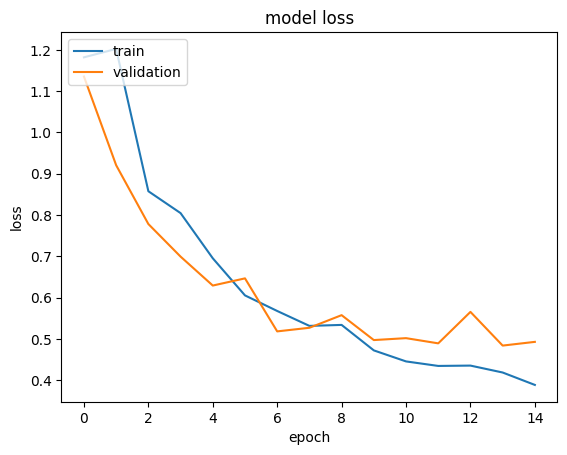

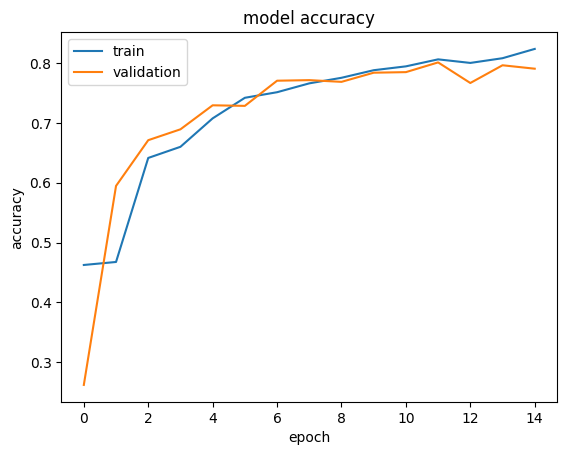

In [ ]:
plot_loss_and_accuracy(history)

10/10 [==============================] - 3s 296ms/step
Confusion Matrix:
[[190  15  37]
 [ 10 183  41]
 [ 24   7 117]]
Accuracy: 79%

Class-wise metrics:
Class: BACTERIA
TPR: 79%
TNR: 91%
FPR: 9%
FNR: 21%

Class: NORMAL
TPR: 78%
TNR: 94%
FPR: 6%
FNR: 22%

Class: VIRUS
TPR: 79%
TNR: 84%
FPR: 16%
FNR: 21%

Balanced Accuracy: 79%



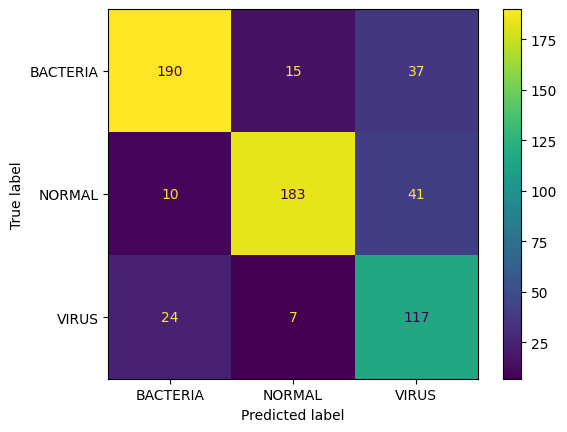

In [ ]:
y_pred = model.predict(test_generator)

y_pred = np.array([np.argmax(inner_array) for inner_array in y_pred]).flatten()
y_test = test_generator.classes
y_test_names = test_generator.class_indices.keys()
display_model_performance_evaluation(y_test, y_pred, y_test_names)

### Saving the model

In [ ]:
model.save(Path(MODELS_DIR, 'task2'))

# Task 3 - KNN
-----
Here, we aim to employ the KNN strategy to facilitate the classification of new images by leveraging both the first and second neural networks developed in the previous tasks.

In [ ]:
def plot_tsne(embeddings, labels, class_to_number):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    number_to_class = {v: k for k, v in class_to_number.items()}

    num_classes = len(class_to_number)
    color_map = plt.cm.tab10

    for i in range(num_classes):
        indices = np.where(labels == i)
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], marker='.', color=color_map(i / num_classes), label=number_to_class[i])

    plt.title('t-SNE Visualization of Embedding Vectors')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()

### Loading models

In [ ]:
model_1 = load_model(Path(MODELS_DIR, 'task1'))
model_2 = load_model(Path(MODELS_DIR, 'task2'))

In [ ]:
embedding_model_1 = Model(inputs=model_1.inputs, outputs=model_1.layers[-2].output)
embedding_model_2 = Model(inputs=model_2.inputs, outputs=model_2.layers[-2].output)

## Task 1

In [ ]:
train_1_generator = data_gen.flow_from_directory(
    TRAIN_1_DIR,
    target_size=(SIZE, SIZE),
    class_mode="binary",
    shuffle=False,
    batch_size=64,
    color_mode="grayscale",
)

test_1_generator = data_gen.flow_from_directory(
    TEST_DIR,
    target_size=(SIZE, SIZE),
    class_mode="binary",
    shuffle=False,
    batch_size=64,
    color_mode="grayscale",
)

### Fitting the KNN model

In [ ]:
embeddings_train1 = embedding_model_1.predict(train_1_generator)
knn1 = KNeighborsClassifier(n_neighbors=5)
knn1.fit(embeddings_train1, train_1_generator.classes)

### Displaying

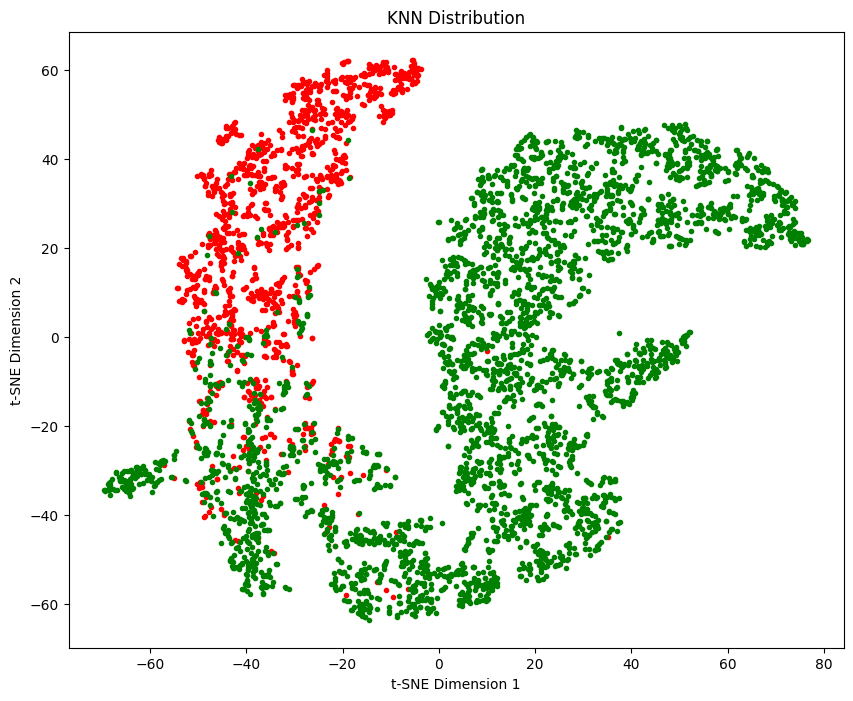

In [ ]:
display_knn_matrix(embeddings_train1, train_1_generator.labels)

### Playground

In [ ]:
image = process_image_for_prediction()
embedding_prediction = embedding_model_1.predict(image)
prediction = knn1.predict(embedding_prediction)[0]

print(list(test_1_generator.class_indices.keys())[prediction])

## Task 2

In [ ]:
train_2_generator = data_gen.flow_from_directory(
    TRAIN_2_DIR,
    target_size=(SIZE, SIZE),
    class_mode="categorical",
    shuffle=False,
    batch_size=64,
    color_mode="grayscale",
)

test_2_generator = data_gen.flow_from_directory(
    TEST_2_DIR,
    target_size=(SIZE, SIZE),
    class_mode="categorical",
    shuffle=False,
    batch_size=64,
    color_mode="grayscale",
)

### Fitting the KNN model

In [ ]:
embeddings_train2 = embedding_model_2.predict(train_2_generator)
knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(embeddings_train2, train_2_generator.classes)

### Disaplying

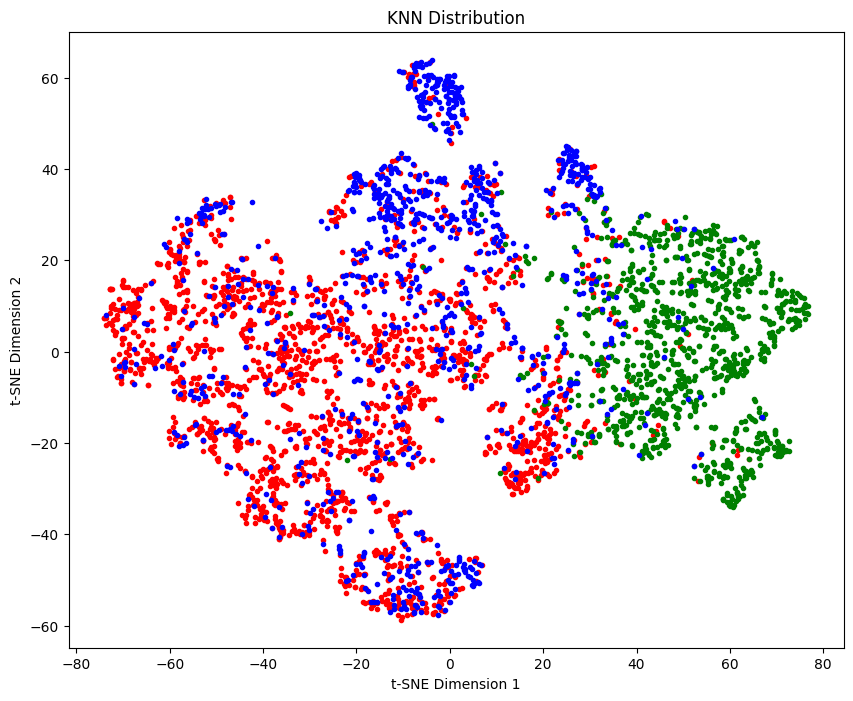

In [ ]:
display_knn_matrix(embeddings_train2, train_2_generator.labels)

### Playground

In [ ]:
image = process_image_for_prediction()
embedding_prediction = embedding_model_2.predict(image)
prediction = knn2.predict(embedding_prediction)[0]

print(list(test_2_generator.class_indices.keys())[prediction])

# Task 4 - Anomaly Detection
-----
In this task, we operate under the assumption that we only possess "normal" lung scans. Our objective is to identify pneumonia scans utilizing the anomaly detection method.

### Loading the data set

In [ ]:
input_shape = (256, 256, 1)
batch_size = 16
epochs = 20

data_generator = ImageDataGenerator(rescale=1./255)

train_generator = data_generator.flow_from_directory(
    '/content/task4/train',
    target_size=input_shape[:2],
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='input',
    shuffle=False
)

test_generator = data_generator.flow_from_directory(
    '/content/task4/test',
    target_size=input_shape[:2],
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='input',
    shuffle=False
)

### Building and Training the model

In [ ]:
from tensorflow.keras.layers import Input

def build_autoencoder(input_shape):
    inputs = Input(shape=input_shape, name='input')
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(inputs, decoded, name='autoencoder')
    autoencoder.compile(optimizer=Adam(), loss='mse')
    return autoencoder

autoencoder = build_autoencoder(input_shape)

autoencoder.fit(train_generator,
                steps_per_epoch=train_generator.samples // batch_size,
                epochs=epochs)

Found 1341 images belonging to 1 classes.
Found 624 images belonging to 2 classes.


### Evaluating model

1/1 [==============================] - 0s 108ms/step


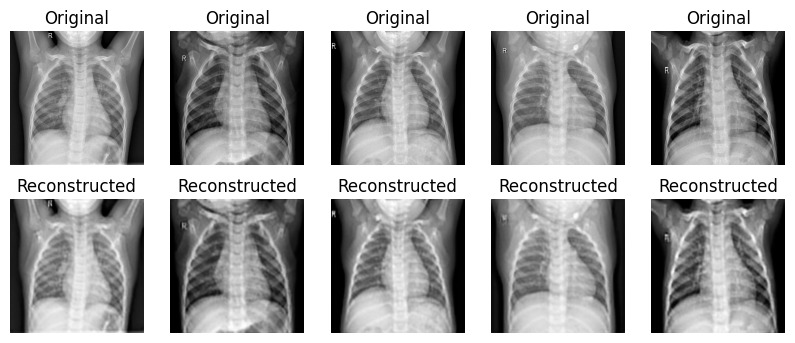

In [ ]:
def visualize_reconstruction(model, generator):
    images, _ = next(generator)
    reconstructed_images = model.predict(images)
    n = min(images.shape[0], 5)
    plt.figure(figsize=(10, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title('Original')
        plt.axis('off')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i].squeeze(), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
    plt.show()

def visualize_reconstruction_histogram(model, generator):
    reconstruction_errors = []
    for i in range(len(generator)):
        batch = generator[i][0]
        reconstruction = model.predict(batch)
        errors = np.mean(np.abs(batch - reconstruction), axis=(1, 2, 3))
        reconstruction_errors.extend(errors)

    plt.hist(reconstruction_errors, bins=50)
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title('Histogram of Reconstruction Errors')
    plt.show()

visualize_reconstruction(autoencoder, train_generator)

1/1 [==============================] - 0s 52ms/step


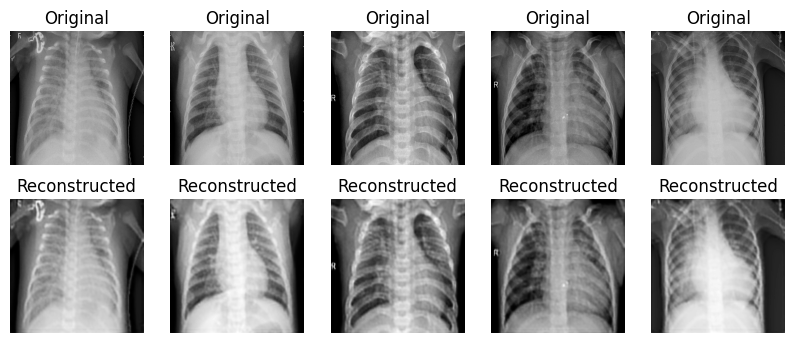

In [ ]:
visualize_reconstruction(autoencoder, test_generator)

1/1 [==============================] - 0s 65ms/step


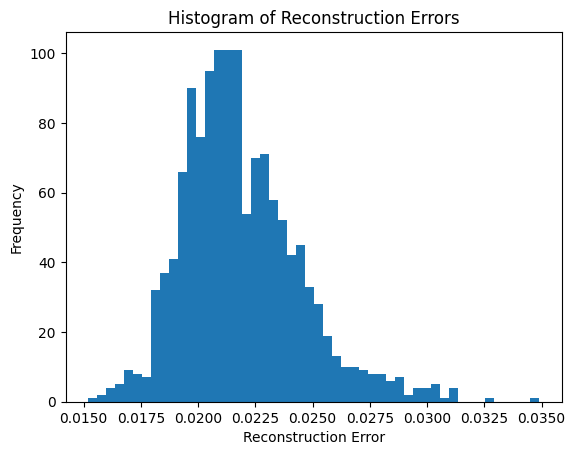

In [ ]:
visualize_reconstruction_histogram(autoencoder, train_generator)

1/1 [==============================] - 0s 29ms/step


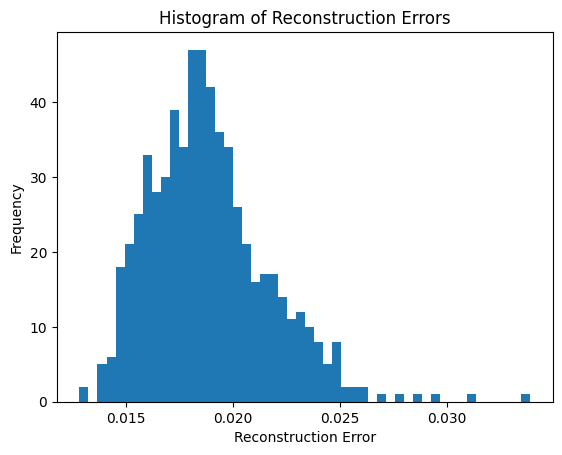

In [ ]:
visualize_reconstruction_histogram(autoencoder, test_generator)

1/1 [==============================] - 0s 31ms/step
Confusion Matrix:
[[116 118]
 [ 60 330]]
Accuracy: 71%

Class-wise metrics:
Class: NORMAL
TPR: 50%
TNR: 85%
FPR: 15%
FNR: 50%

Class: PNEUMONIA
TPR: 85%
TNR: 50%
FPR: 50%
FNR: 15%

Balanced Accuracy: 67%



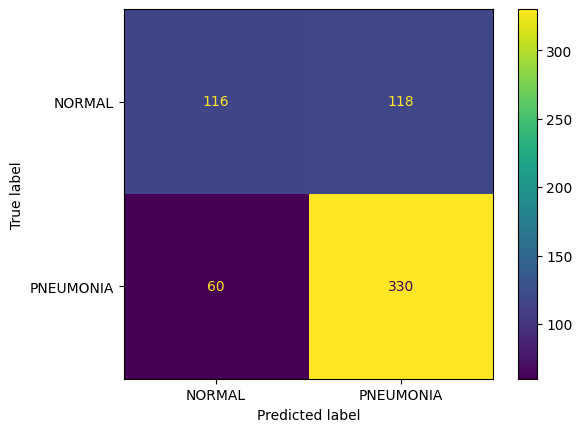

In [ ]:
THRESHOLD = 0.02

y_pred = []
for i in range(len(test_generator)):
    images = test_generator[i][0]
    predictions = autoencoder.predict(images)
    mse_batch = np.mean(np.abs(images - predictions), axis=(1, 2, 3))
    y_pred.extend(int(mse > THRESHOLD) for mse in mse_batch)
display_model_performance_evaluation(test_generator.classes, y_pred, ['NORMAL', 'PNEUMONIA'])

### Saving the model

In [ ]:
autoencoder.save(Path(MODELS_DIR, 'task4'))

### Playground

In [ ]:
def detect_anomaly(img_array, model, threshold):
    reconstructed_img = model.predict(img_array)
    loss = np.mean(np.abs(reconstructed_img - img_array))
    print(loss)
    if loss > threshold:
        print("Anomaly detected!")
    else:
        print("No anomaly detected.")

img = process_image_for_prediction(size=256)

detect_anomaly(img, autoencoder, THRESHOLD)